# Scraping and Exploration of NSW Food Authority Register of Penalty Notices

There's been some recent noise around the NSW Department of Primary Industries Food Authority's naming and shaming of restaurants [here](http://www.foodauthority.nsw.gov.au/penalty-notices/default.aspx?template=results). As you can see, there's a nice embedded table so let's so how we can scrape out this information and do some exploration.

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
plt.style.use("ggplot")

We're going to use BeautifulSoup to scrape the table data. Upon inspection we can see that this should be fairly easy, as the HTML is fairly standard. We'll set up a skeleton dataframe and populate this.

In [4]:
url = "http://www.foodauthority.nsw.gov.au/penalty-notices/default.aspx?template=results"

r = requests.get(url)
soup = BeautifulSoup(r.text, "lxml")      
table = soup.find_all("table")

df = pd.DataFrame(columns = ['trade_name', 'suburb', 'council', 'penalty_no',
                             'date', 'party_served', 'desc'])


The way our scraper will work is it will iterate through all tables, then iterate through all rows and columns. It will effectively write each row into a row of our dataframe.

In [7]:
for t in table:
    table_body = t.find('tbody')
    try:
        rows = table_body.find_all('tr')
        for tr in rows:
            temp = []
            try:
                cols = tr.find_all('td')
                href = cols[3].find_all('a')
                temp.append(href[0].get('title'))
                for col in cols:
                    try:
                        temp.append(col.string.strip())
                    except:
                        pass
                
                df = df.append(pd.Series(temp, df.columns), ignore_index = True)
            
            except:
                print("Error reading row.")
                
        
    except:
        print("Error reading table body.")

In [9]:
df.head()

,trade_name,suburb,council,penalty_no,date,party_served,desc
0,Fail to transport potentially hazardous food u...,(NO TRADING NAME),CHATSWOOD,Willoughby,3136844078,2016-08-10,"CHOI, JUNG DAE"
1,Fail to comply with a condition of licence - h...,(NO TRADING NAME),NAROOMA,Eurobodalla,3120777249,2016-01-05,"DON MANUWELLGE DON, ANOMA"
2,Sale of unsafe food - sushi,(NO TRADING NAME),RYDALMERE,Parramatta,3013503947,2016-01-19,"PARK, JI YOUNG"
3,Fail to maintain the food premises to the requ...,3 CHIMNEYS,WOLLONGONG,Wollongong,3132275255,2016-05-20,DRB 56 PTY LTD
4,"Fail to maintain all fixtures, fittings and eq...",3 CHIMNEYS,WOLLONGONG,Wollongong,3132275264,2016-05-20,DRB 56 PTY LTD


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 7 columns):
trade_name      1504 non-null object
suburb          1504 non-null object
council         1504 non-null object
penalty_no      1504 non-null object
date            1504 non-null object
party_served    1504 non-null object
desc            1504 non-null object
dtypes: object(7)
memory usage: 82.3+ KB


In [12]:
df.columns = ["desc", "trade_name", "suburb", "council", "number", "date", "party_served"]
df.number = np.int64(df.number)
df.head()

,desc,trade_name,suburb,council,number,date,party_served
0,Fail to transport potentially hazardous food u...,(NO TRADING NAME),CHATSWOOD,Willoughby,3136844078,2016-08-10,"CHOI, JUNG DAE"
1,Fail to comply with a condition of licence - h...,(NO TRADING NAME),NAROOMA,Eurobodalla,3120777249,2016-01-05,"DON MANUWELLGE DON, ANOMA"
2,Sale of unsafe food - sushi,(NO TRADING NAME),RYDALMERE,Parramatta,3013503947,2016-01-19,"PARK, JI YOUNG"
3,Fail to maintain the food premises to the requ...,3 CHIMNEYS,WOLLONGONG,Wollongong,3132275255,2016-05-20,DRB 56 PTY LTD
4,"Fail to maintain all fixtures, fittings and eq...",3 CHIMNEYS,WOLLONGONG,Wollongong,3132275264,2016-05-20,DRB 56 PTY LTD


Looking good. We've scraped out all the data, adjusted the column names and forced the penalty ID to be a number. Interestingly though, on the table we see that each penalty ID links to a seperate page which contains even more information. This will be a little trickier to scrape.

In [ ]:
url_2 = "http://www.foodauthority.nsw.gov.au/penalty-notices/default.aspx?template=detail&itemId="

df_2 = pd.DataFrame(columns = ["number", "trade_name", "address", "council",
                                "date_of_offence", "offence_code", "nature",
                                "penalty", "party_served", "date_served",
                                "issuer"])

for id_2 in df["penalty_id"]:
    temp_url = url_2 + id_2
    r = requests.get(temp_url)
    soup = BeautifulSoup(r.text, "lxml")
    table = soup.find_all("table")
    
    for t in table:
        table_body = t.find('tbody')
        
        try:
            rows = table_body.find_all('tr')
            temp = []
            for tr in rows:
                try:
                    col = tr.find_all('td')
                    column_1 = col[1].string.strip()
                    temp.append(column_1)
                    
                except:
                    print("Error in row.")
        
        
        except:
            print("Error in table body.")
            
    df_2 = df_2.append(pd.Series(temp, df_2.columns), ignore_index = True)



In [15]:
df_2.head()

,number,trade_name,address,council,date_of_offence,offence_code,nature,penalty,party_served,date_served,issuer
0,3136844078,(NO TRADING NAME),CENTENNIAL AVENUE CHATSWOOD 2067,Willoughby,10-08-16,11338 - Fail to comply with Food Standards Cod...,Fail to transport potentially hazardous food u...,$440,"CHOI, JUNG DAE",11-08-16,Willoughby City Council
1,3120777249,(NO TRADING NAME),2 RIVERSIDE DRIVE NAROOMA 2546,Eurobodalla,05-01-16,11016 - Contravene condition of licence - Indi...,Fail to comply with a condition of licence - h...,$660,"DON MANUWELLGE DON, ANOMA",19-07-16,NSW Food Authority
2,3013503947,(NO TRADING NAME),33 MARY PARADE RYDALMERE 2116,Parramatta,19-01-16,11318 - Sell unsafe food - Individual,Sale of unsafe food - sushi,$770,"PARK, JI YOUNG",19-05-16,NSW Food Authority
3,3132275255,3 CHIMNEYS,3/63-65 CROWN STREET WOLLONGONG 2500,Wollongong,20-05-16,11339 - Fail to comply with Food Standards Cod...,Fail to maintain the food premises to the requ...,$880,DRB 56 PTY LTD,23-05-16,Wollongong City Council
4,3132275264,3 CHIMNEYS,3/63-65 CROWN STREET WOLLONGONG 2500,Wollongong,20-05-16,11339 - Fail to comply with Food Standards Cod...,"Fail to maintain all fixtures, fittings and eq...",$880,DRB 56 PTY LTD,23-05-16,Wollongong City Council


We can see that we've gotten a lot more information this time. Street address, penalty amounts as well as the specific codes which have been breached. Lets combine our two dataframes and simplify them down so we have a nice dataset to work with.

In [18]:
df_full = pd.merge(df, df_2, on = "number", how = "left", suffixes = ("_basic", "full"))
df_full = df_full.drop(["trade_namefull", "councilfull", "date_of_offence", "party_servedfull"], axis = 1)
df_full["penalty"] = df_full["penalty"].str.replace("$", "")
df_full["penalty"] = np.int64(df_full["penalty"].str.replace(",", ""))
df_full.head()

,desc,trade_name_basic,suburb,council_basic,number,date,party_served_basic,address,offence_code,nature,penalty,date_served,issuer
0,Fail to transport potentially hazardous food u...,(NO TRADING NAME),CHATSWOOD,Willoughby,3136844078,2016-08-10,"CHOI, JUNG DAE",CENTENNIAL AVENUE CHATSWOOD 2067,11338 - Fail to comply with Food Standards Cod...,Fail to transport potentially hazardous food u...,440,11-08-16,Willoughby City Council
1,Fail to comply with a condition of licence - h...,(NO TRADING NAME),NAROOMA,Eurobodalla,3120777249,2016-01-05,"DON MANUWELLGE DON, ANOMA",2 RIVERSIDE DRIVE NAROOMA 2546,11016 - Contravene condition of licence - Indi...,Fail to comply with a condition of licence - h...,660,19-07-16,NSW Food Authority
2,Sale of unsafe food - sushi,(NO TRADING NAME),RYDALMERE,Parramatta,3013503947,2016-01-19,"PARK, JI YOUNG",33 MARY PARADE RYDALMERE 2116,11318 - Sell unsafe food - Individual,Sale of unsafe food - sushi,770,19-05-16,NSW Food Authority
3,Fail to maintain the food premises to the requ...,3 CHIMNEYS,WOLLONGONG,Wollongong,3132275255,2016-05-20,DRB 56 PTY LTD,3/63-65 CROWN STREET WOLLONGONG 2500,11339 - Fail to comply with Food Standards Cod...,Fail to maintain the food premises to the requ...,880,23-05-16,Wollongong City Council
4,"Fail to maintain all fixtures, fittings and eq...",3 CHIMNEYS,WOLLONGONG,Wollongong,3132275264,2016-05-20,DRB 56 PTY LTD,3/63-65 CROWN STREET WOLLONGONG 2500,11339 - Fail to comply with Food Standards Cod...,"Fail to maintain all fixtures, fittings and eq...",880,23-05-16,Wollongong City Council


## Exploration!
Time to dig into the details and see what we can find out from this dataset.

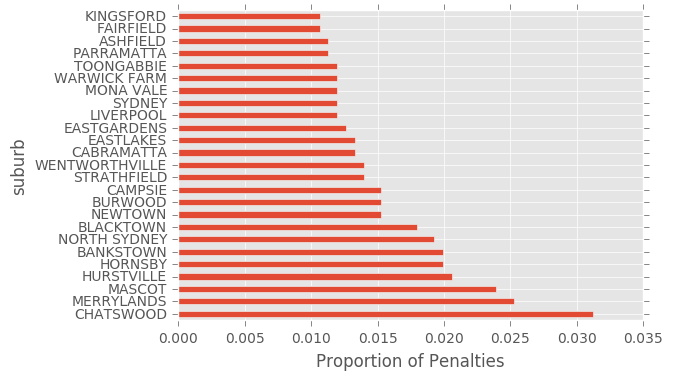

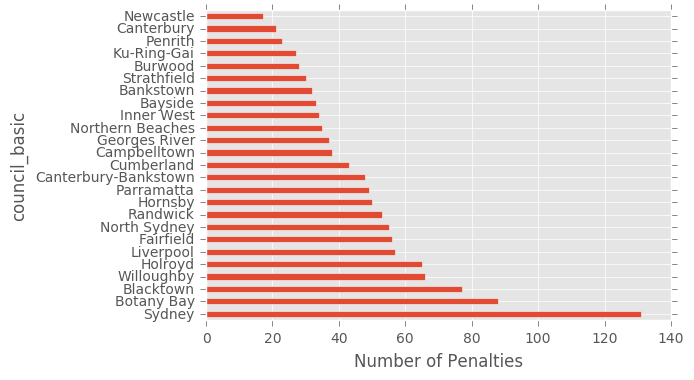

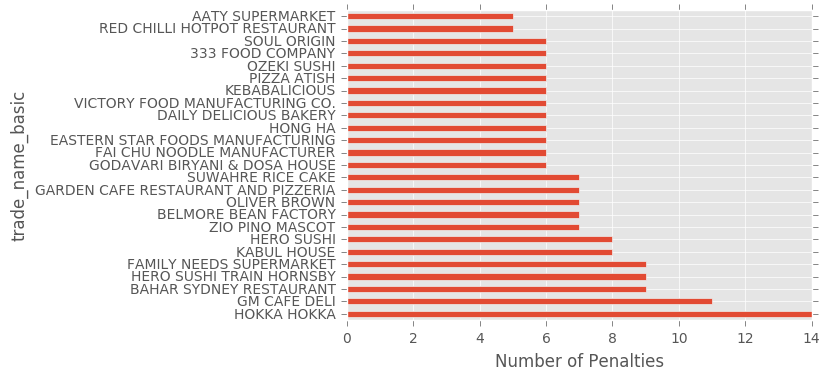

In [22]:
(df_full.groupby(["suburb"]).count()["desc"]/df.shape[0]).sort_values(ascending=False)[0:25].plot(kind="barh")
plt.xlabel("Proportion of Penalties")
plt.show()

df_full.groupby(["council_basic"]).count()["date"].sort_values(ascending=False)[0:25].plot(kind="barh")
plt.xlabel("Number of Penalties")
plt.show()

df_full.groupby(["trade_name_basic"]).count()["date"].sort_values(ascending=False)[0:25].plot(kind="barh")
plt.xlabel("Number of Penalties")
plt.show()

Coming out strong we see that Chatswood dominates the suburb infringement, whilst Sydney leads the overall council issuance. In terms of total number of penalties, Hokka Hokka leads the way with 14 penalties in the last year!

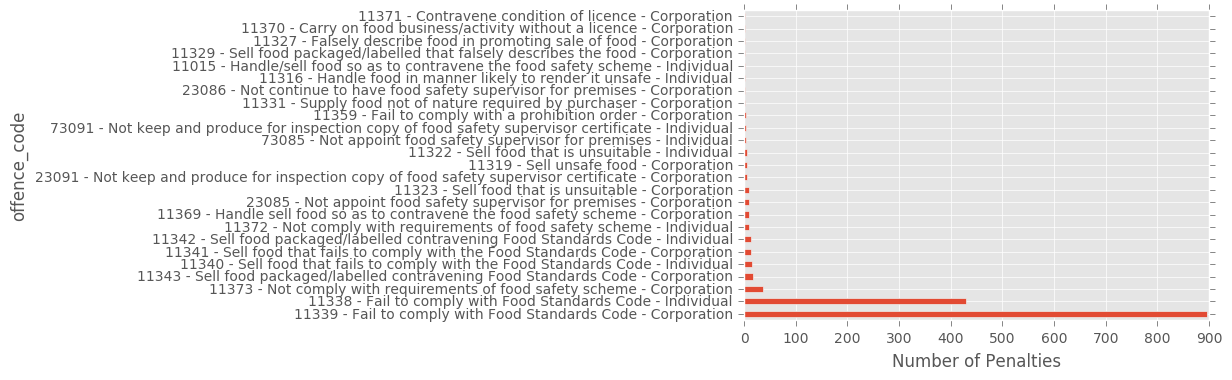

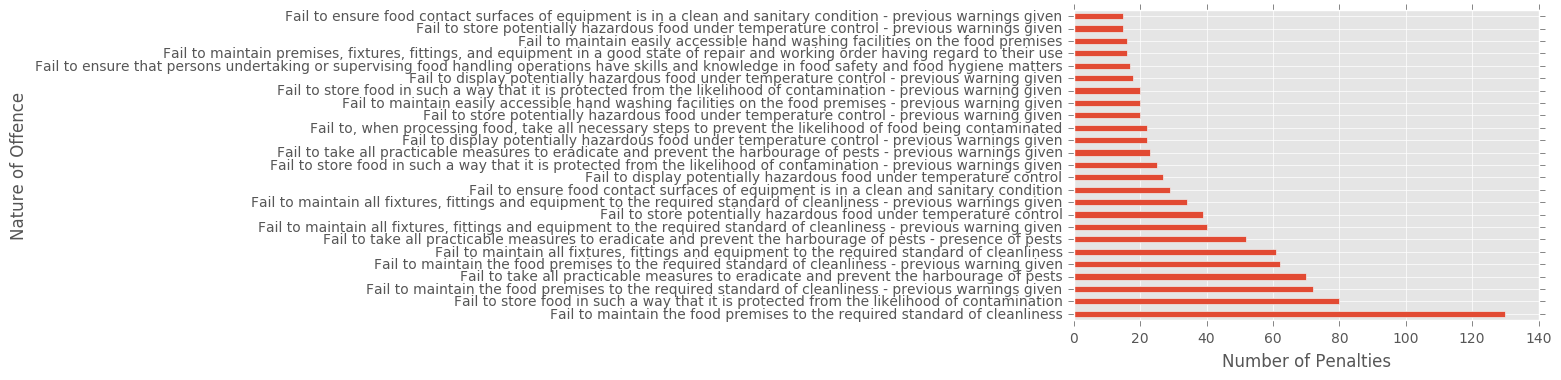

In [26]:
df_full.groupby(["offence_code"]).count()["date"].sort_values(ascending=False)[0:25].plot(kind='barh')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel("Number of Penalties")
plt.show()

df_full.groupby(["nature"]).count()["date"].sort_values(ascending=False)[0:25].plot(kind='barh')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel("Number of Penalties")
plt.ylabel("Nature of Offence")
plt.show()

A bit unclear, but we can see that offence code "11339 - Fail to comply with Food Standards Code - Corporation" is the clear winner in number of penalties. Not unexpectedly, restuarant cleanliness and food storage the leaders in infrigements.

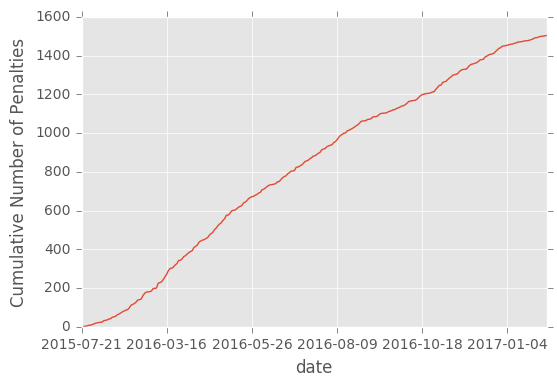

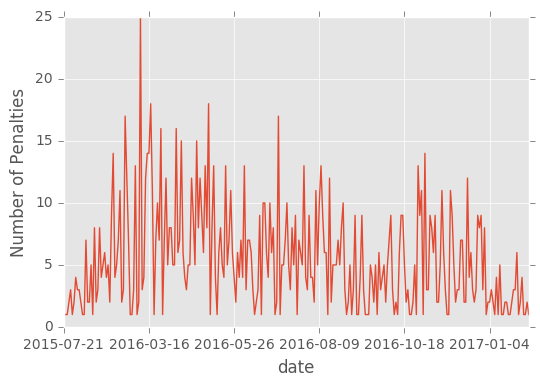

In [28]:
df_full.groupby(["date"]).count()["penalty"].cumsum().plot()
plt.ylabel("Cumulative Number of Penalties")
plt.show()

df_full.groupby(["date"]).count()["penalty"].plot()
plt.ylabel("Number of Penalties")
plt.show()

We see a pretty large spike in penalties occuring early March 2016! Perhaps there was some sort of Government initiative which drove this, or maybe it was just an unusually bad period of the year. Ideally we could get a longer dataset to draw out some better conclusions on trends in penalty notices.

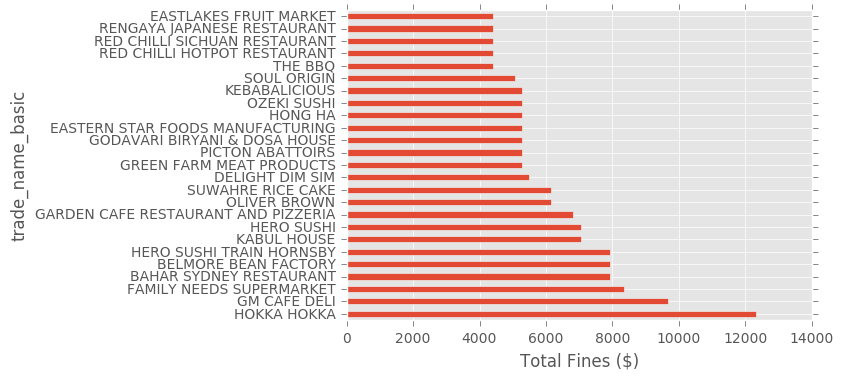

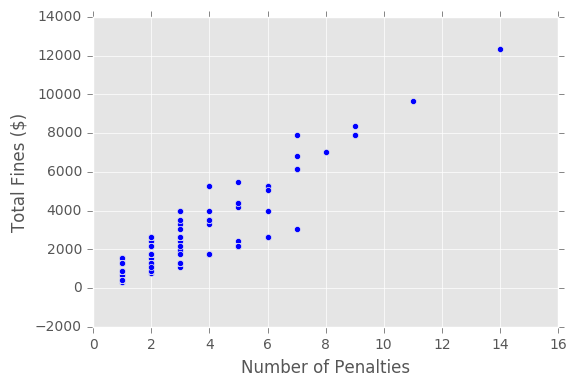

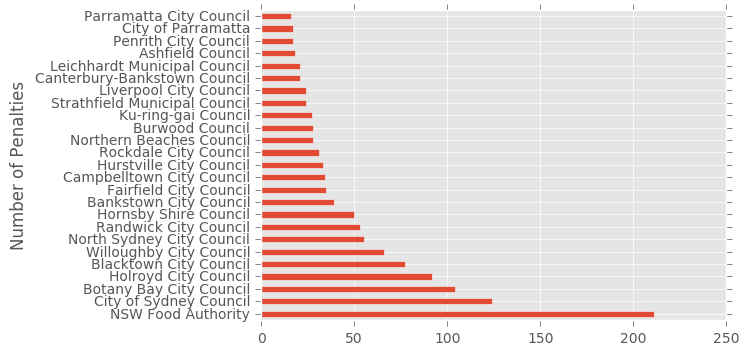

In [32]:
df_full.groupby(["trade_name_basic"]).sum()["penalty"].sort_values(ascending=False)[0:25].plot(kind="barh")
plt.xlabel("Total Fines ($)")
plt.show()

temp = df_full.groupby(["trade_name_basic"]).sum()
temp["count"] = df_full.groupby(["trade_name_basic"]).count()["penalty"]

plt.scatter(temp["count"], temp["penalty"])
plt.xlabel("Number of Penalties")
plt.ylabel("Total Fines ($)")
plt.show()

df_full.groupby(["issuer"]).count()["penalty"].sort_values(ascending=False)[0:25].plot(kind="barh")
plt.ylabel("Number of Penalties")
plt.show()

As expected, there's a strong lienar trend in the number of penalties received and the total fine amount. We also see that the NSW Food Authority is taking clear lead over the councils in terms of penalty issuance.


We'll close out for now with an attempt at a word cloud...

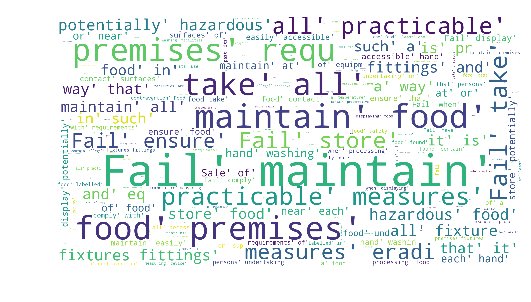

In [36]:
from wordcloud import WordCloud, STOPWORDS

text = df_full["nature"].to_string()
text = str(text.split())

stopwords = set(STOPWORDS)
stopwords.add("to'")
stopwords.add("the'")

wordcloud = WordCloud(background_color = "white", max_words = 200, 
                      stopwords = stopwords, width = 2600, height = 1400).generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()